In [6]:
import os
os.environ['http_proxy'] = '127.0.0.1:7890'
os.environ['https_proxy'] = '127.0.0.1:7890'

In [7]:
import ee
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import plotnine
from plotnine import *

import rasterio

import itertools
import difflib
import sys
import requests
from tqdm.auto import tqdm
from pprint import pprint

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table

In [8]:
# authenticate earthengine api
ee.Initialize()

In [9]:
from Modules.Modules import filter_exclude, get_img_df, compute_mean_ci
from Modules.Parallize_df import parallelize_dataframe

# might need reload modules as the code progrocessing
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# import GAEZ data from ee_asset
GAEZ_list = ! earthengine ls users/wangjinzhulala/Paper_3/03_GAEZ

# import NCL shp
NCP_shp = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_province_boundry")
NCP_cities = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_city_boundary")

# get the GAEZ pixel size
GAEZ_pix_scale = ee.Image("users/wangjinzhulala/Paper_3/03_GAEZ/GAEZ_2_Moisture_Annual_P_PET_1981_2010_Historical").projection().nominalScale().getInfo()

# pair Chinese city names with english spelling
city_cn_en = dict(zip(['北京市','天津市', '河北省','江苏省', '安徽省', '河南省', '山东省'],
             ['Beijing','Tianjin', 'Hebei','Jiangsu', 'Anhui', 'Henan', 'Shandong']))

## 1. Compute yield conversion ratio

- For maize, it's 0.87.
- For wetland rice it's 0.875 (0.9 for dryland rice)
- For wheat it's 0.875. 

#### Load yield data from [ 'Attainable']

In [11]:
# get the historical_attainable_yield
interpolate_df_full = pd.read_pickle('./result_csv/attainable_yield_interpolated.pkl')

attainable_historical = interpolate_df_full[[str(i) in (['1975','1985','1995','2010']) for i in interpolate_df_full['year'].tolist()]]
attainable_historical = attainable_historical.drop(['img_future_sd','img_future_ci'],1)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_10592\3698671651.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.


## 2. Convert GAEZ attainable yield (kg DW/ha) to actual yield (kt/ha)

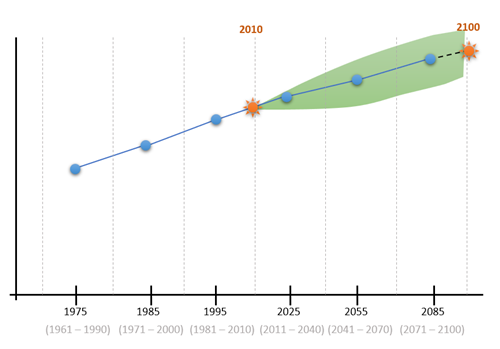

In [12]:
# get the critical years
attainable_anchors = interpolate_df_full[[str(i) in (['1975','1985','1995','2010','2025','2055','2085','2100']) 
                          for i in interpolate_df_full['year'].tolist()]]

# # remove Rainfed Wetland_rice since this crop never shows in the actual yield records
# attainable_anchors = attainable_anchors[~((attainable_anchors['crop']=='Wetland_rice')&
#                        (attainable_anchors['water']=='Rainfed'))].reset_index(drop=True)

In [13]:
# get the area ratio for Rainfed/Irrigated, the ratio will be used as weights
# to compute: mean_yield = (crop_rainfed)*(rainfed_ratio) + (crop_irrigated*irrigated_ratio)
def compute_area_ratio(row):

  crop = row['crop']
  water = row['water']
  img = ee.Image(row['GEE_path'])
  
  # note the Rainfed Wetland_rice is not avaliable in actual yield,
  # so we exclude it here
  if crop == 'Wetland_rice':
    if water == 'Rainfed':
      return ee.Image(0)
    else:
      return ee.Image(1)

  img_areas = [ee.Image(i) for i in actual_area[actual_area['crop']==crop]['GEE_path'].tolist()]
  img_total_area = ee.ImageCollection(img_areas).sum()
  img_area_ratio = img.divide(img_total_area)

  return img_area_ratio

In [14]:
# function to get attianable yield for each province
def get_attainable_conveted_yield(in_df):

  # hack to show progress bar
  print(' ',end='',flush=True)

  df_list = []

  # compute the total attainable yield in each provinces
  for idx,row in tqdm(in_df.iterrows(),total=len(in_df)):
    crop = row['crop']
    water = row['water']
    year = row['year']
    rcp = row['rcp']

    img_val = row['convert_actual_yield_val_weighted']
    img_ds = ee.Image(0) if year<=2010 else row['convert_actual_yield_sd_weighted']
    img = ee.Image([img_val,img_ds]).rename(['val','sd'])
    # compute stats from GEE
    stats = img.reduceRegions(collection=NCP_shp,reducer='mean',scale=GAEZ_pix_scale).getInfo()

    # get data
    stats_df = pd.DataFrame({i['properties']['NAME']:[i['properties']['val']] for i in stats['features']}).T
    stats_df['sd'] = [i['properties']['sd'] for i in stats['features']] 

    # append infomation
    stats_df = stats_df.reset_index()
    stats_df.columns=['Province','Mean Production','sd']
    stats_df['water'] = water
    stats_df['crop'] = crop
    stats_df['year'] = year
    stats_df['rcp'] = rcp

    stats_df['top'] = stats_df['Mean Production'] + stats_df['sd']
    stats_df['bot'] = stats_df['Mean Production'] - stats_df['sd']


    # convert attainable yield (kg DW/ha) to practical yield (t/ha)
    ratio = 0.87/1000 if crop == "Maize" else 0.875/1000
    stats_df['Mean Production'] = stats_df['Mean Production'] * ratio
    stats_df['top'] = stats_df['top'] * ratio
    stats_df['bot'] = stats_df['bot'] * ratio


    # CN to EN
    stats_df['Province'] = stats_df.apply(lambda x:city_cn_en[x['Province']],1)

    # store df                        
    df_list.append(stats_df)

  # concat dfs
  out_df = pd.concat(df_list).reset_index(drop=True)
  
  return out_df

In [15]:
# actual harvested area
actual_area = get_img_df(img_path = GAEZ_list,
              theme = 'GAEZ_5',
              variable = ['Harvested_area'],
              time = '2010',
              crop = ['Maize','Wetland_rice','Wheat'],
              water = ['Rainfed','Irrigated'])

# get the crop area ratio for different water type
actual_area['area_ratio'] = actual_area.apply(lambda row:compute_area_ratio(row),1)
actual_area = actual_area[['crop','water','area_ratio']]

# save to disk
actual_area.to_pickle('./result_csv/harvested_area_ratio.pkl')

In [16]:
##################### Multiply each crop_water with its area_ratio #############
anchor_attainable_converted = attainable_anchors.merge(actual_area,on=['crop','water'])

# compute the area_weighted actual yield
anchor_attainable_converted['convert_actual_yield_val_weighted'] = anchor_attainable_converted.apply(lambda x:x['image'].multiply(x['area_ratio']),1)
anchor_attainable_converted['convert_actual_yield_sd_weighted'] = anchor_attainable_converted.apply(lambda x:ee.Image(x['img_future_sd']).multiply(x['area_ratio']),1)

#################### Get the mean production for each province ###########################
anchor_attainable_converted_df = parallelize_dataframe(anchor_attainable_converted,get_attainable_conveted_yield,10)

# sum rainfed/irrigated together
anchor_attainable_converted_df = anchor_attainable_converted_df.groupby(['crop','Province','year','rcp']).sum().reset_index()
anchor_attainable_converted_df.to_csv('./result_csv/anchor_attainable_converted_df.csv',index=False)

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

C:\Users\Administrator\AppData\Local\Temp\ipykernel_10592\4109513684.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


Seeing above historical attainbale-yield, we can conclude that the historical climate change has less impcats to crop yield. This conclusion is very strange as we know the climate change since 1980 was also siginificant. I assume two reasons led to such result:
- The historical GAEZ data is bad, which lead to unreasonable results
- The historical climate change (1975-2010) is not so significant compared to current magnitude.

#### Get the actual production from yearbook

In [17]:
# function to read yearbook csv and orginize data
def read_csv(path,crop):

  # read and reshape data to long format
  df = pd.read_csv(path)
  df = df.set_index('地区')
  df = df.stack().reset_index()
  df.columns = ['Province','year','Mean Production']
  df['year'] = df['year'].apply(lambda x: int(x[:4]))
  df['crop'] = crop

  # fitler df and replace CN to EN
  df = df[df['Province'].isin(city_cn_en.keys())]
  df = df.replace(city_cn_en)

  # remove 0s
  df = df[df['Mean Production']!=0]

  return df

In [19]:
# read data and concat to a single df
wheat_yield_history = read_csv('../Data/06_Yearbook/Agricultural_production/Provincial_historical_yield/Provincial_wheat_yield.csv','Wheat')
rice_yield_history = read_csv('../Data/06_Yearbook/Agricultural_production/Provincial_historical_yield/Provincial_rice_yield.csv','Wetland_rice')
maize_yield_history = read_csv('../Data/06_Yearbook/Agricultural_production/Provincial_historical_yield/Provincial_maize_yield.csv','Maize')

crop_yield_history = pd.concat([wheat_yield_history,rice_yield_history,maize_yield_history]).reset_index(drop=True)

# convert t/ha to kt/ha, so the uint is consistent with GAEZ
crop_yield_history['Mean Production'] = crop_yield_history['Mean Production']/1000
crop_yield_history['rcp'] = 'Yearbook'

# filter records for plotting
crop_yield_history_1975_2020 = crop_yield_history[(crop_yield_history['year']<2020)&(crop_yield_history['year']>=1975)]
crop_yield_history_1975_2020.to_csv('./result_csv/crop_yield_history_1975_2020.csv',index=False)

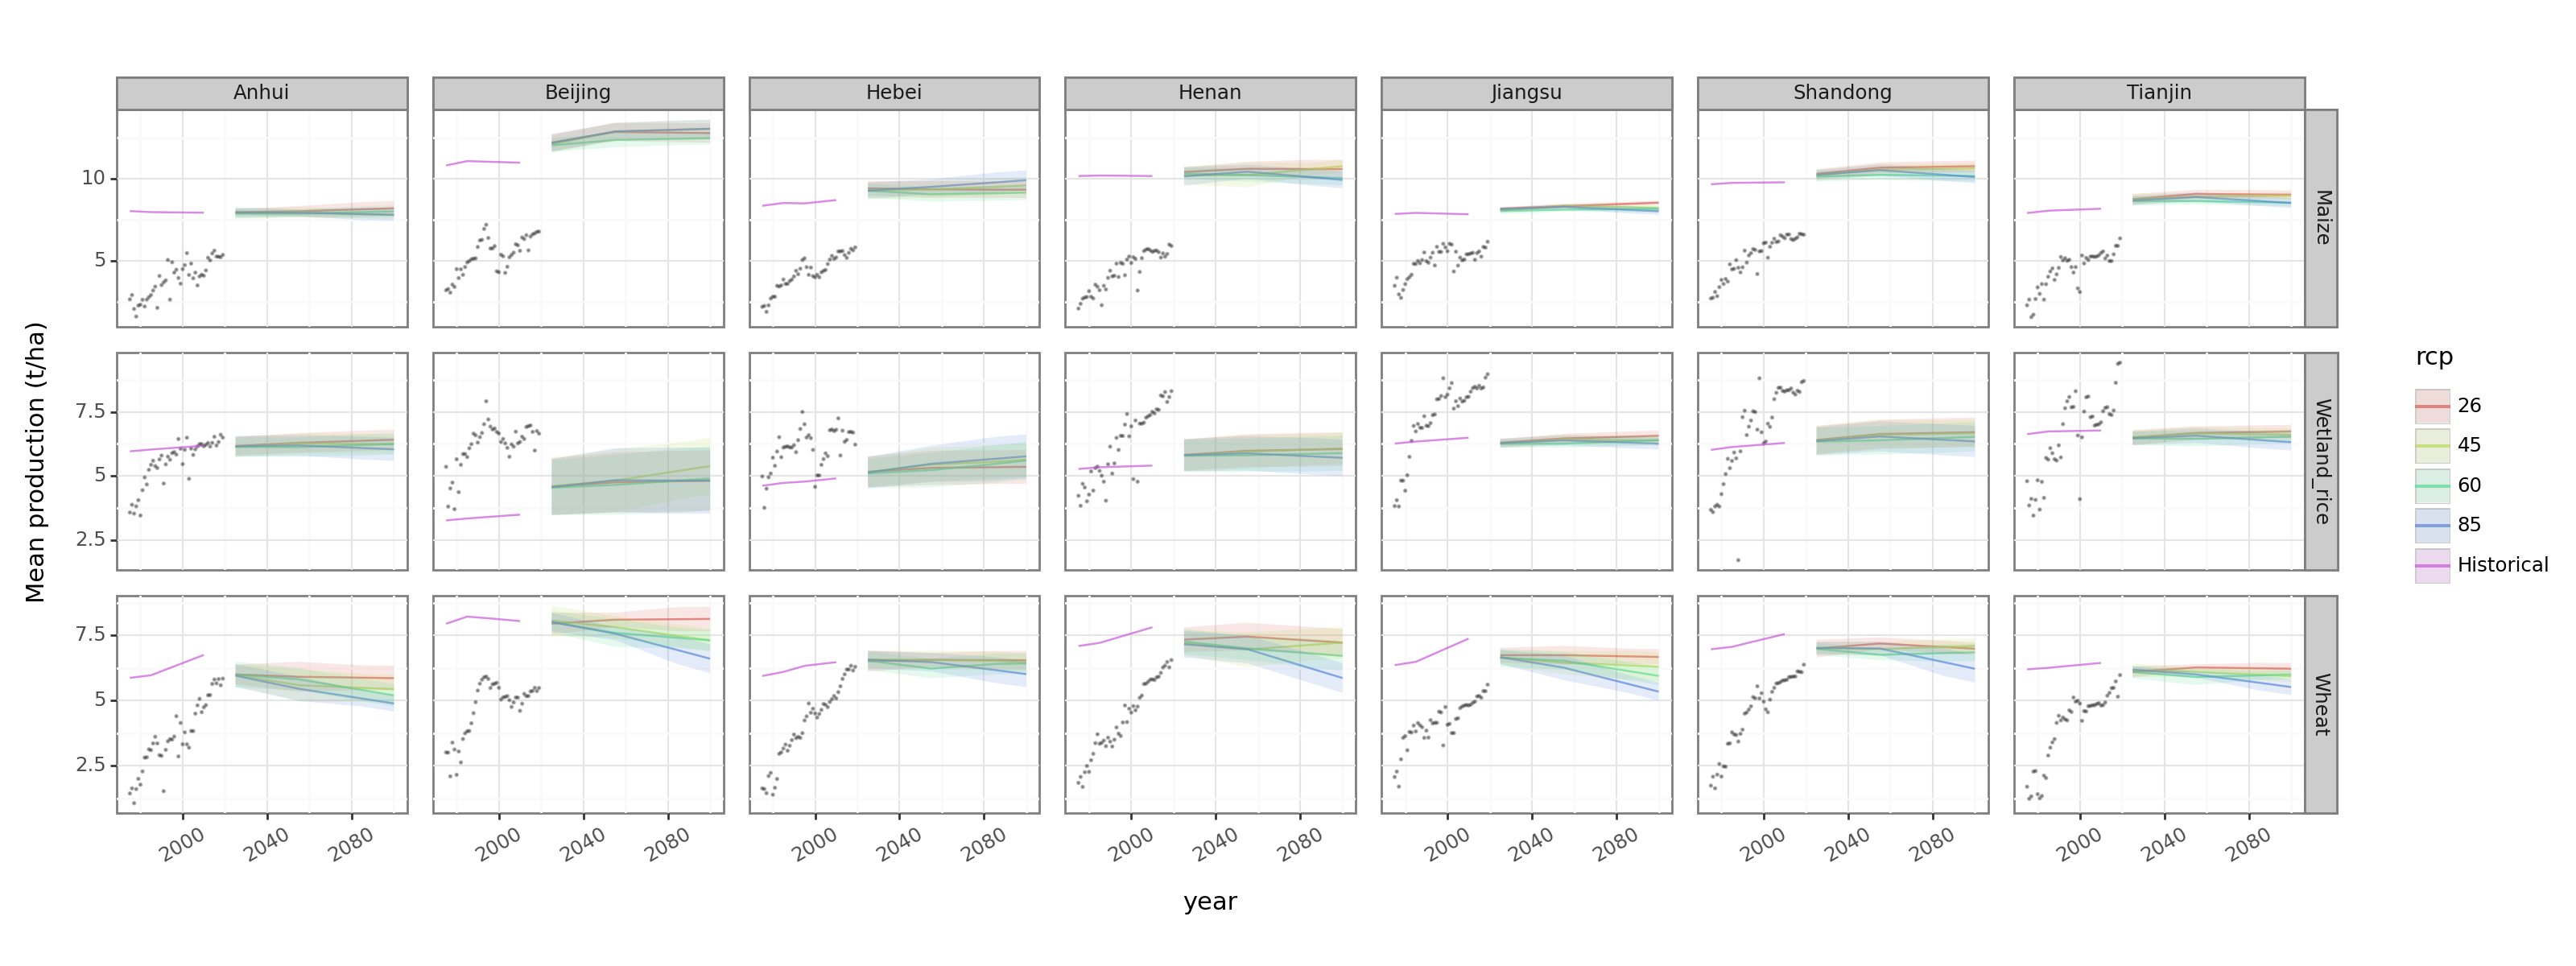

<Figure Size: (1600 x 600)>

In [20]:
plotnine.options.figure_size = (16, 6)
plotnine.options.dpi = 100

g = (ggplot() +
 # yearbook yield
 geom_point(crop_yield_history_1975_2020, aes('year','Mean Production'),size=0.1,alpha=0.3) +
 # attainable yield
 geom_line(anchor_attainable_converted_df, aes('year','Mean Production',color='rcp'),alpha=0.7) +
 geom_ribbon(anchor_attainable_converted_df, aes(x='year',ymax='top',ymin='bot',fill='rcp'),alpha=0.15) +
 facet_grid('crop~Province',scales='free') +
 theme_bw() + 
 theme(axis_text_x=element_text(rotation=30)) +
 ylab('Mean production (t/ha)')
)

g

In [21]:
g.save('../Figs/sup_12_attianabe_yield_no_correction.svg')

C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 16 x 6 in image.
C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../Figs/sup_12_attianabe_yield_no_correction.svg
